In [12]:
import pandas as pd
import torch, torchdata, torchtext
from torch import nn
import time
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 2422
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


cpu


In [13]:
torch.__version__

'1.13.1+cpu'

In [14]:
torchtext.__version__

'0.14.1'

## Load the given dataset

1. Create a variable to your dataset PATH *example:  ./data/*
2. Load the csv files using pandas 



In [15]:
data_yelp = pd.read_csv("sample_submission.csv")

train_data_raw = pd.read_csv("train.csv") 
test_data_raw = pd.read_csv("test.csv")

In [16]:
data_yelp.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [17]:
train_data_raw.shape

(7613, 5)

In [18]:
test_data_raw.shape

(3263, 4)

In [19]:
## Lets analyze the data a little

#print and show how many unique classes are in the target

classes = train_data_raw.target.value_counts() #Sentiment analysis only 0 or 1
num_classes = len(classes)
num_classes

2

In [20]:
assert num_classes > 1

In [21]:
##lets see how many columns are there
#print the columns of the train_data_raw

print(len(test_data_raw)) #write your code here

3263


1. Lets remove the keywords and location columns. We only want to focus on the text and the predictions
2. Lets split some training data to validation dataset

In [22]:
SPLIT_PER = 2 #percentage of split for validation set 2 = 2%
split =  int(len(train_data_raw) * (SPLIT_PER/100))

dropped_train = train_data_raw.drop(columns=['id', 'keyword', 'location']) #drop the id, keyowrd and location columns from the train_data_raw

train_data = dropped_train[:-split]
valid_data = dropped_train[-split:]
assert train_data.shape == (len(train_data_raw) - split, 2)
assert valid_data.shape == (split, 2)

In [23]:
print(train_data_raw.shape)
print("After dropping columns and spliting!")
print(train_data.shape, valid_data.shape)
 

(7613, 5)
After dropping columns and spliting!
(7461, 2) (152, 2)


## Lets tokenize the data

In [37]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy',language='en_core_web_sm')
 
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

In [38]:
for i in train_data.values:
    print (i)
    break

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all' 1]


In [39]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for text, _ in data_iter.itertuples(index=False):
        yield tokenizer(text)
    #loop through the data_iter, 
    # Mind that the data_iter in this case is pandas Dataframe
    # pass #remove this line and code here

specials = ['<unk>','<pad>','<bos>','<eos>'] #create array of special tags for the vocab
vocab  = build_vocab_from_iterator(yield_tokens(train_data), specials = specials, special_first=True)

#set_default_index of the vocab to unknown tag
vocab.set_default_index(vocab["<unk>"]) #if you don't the id of this word, set it unk

In [40]:
assert len(vocab) == 26442

In [41]:
vocab_dict = vocab.get_stoi()
vocab_dict

{'bells': 17043,
 'Escaping': 12472,
 'charge': 2966,
 "'m": 59,
 'putin': 24713,
 'adoption': 6850,
 'STILL': 6529,
 'WOUNDS': 16371,
 'Mafia': 6212,
 'mass': 200,
 'Lubbock': 6184,
 'Gillibrand': 12913,
 'Scarlet': 15416,
 'depreciations': 17800,
 'Bomb': 1013,
 '@WoundedPigeon': 9949,
 'lvl': 23796,
 'advice': 16695,
 '.': 6,
 'restore': 3119,
 'dominant': 17956,
 'thunder': 475,
 '.@NorwayMFA': 8190,
 'pitch': 3866,
 '@9NewsBrisbane': 8744,
 'Odell': 14460,
 'Quarantine': 761,
 'point': 1142,
 '@ByTorrecilla': 8925,
 'fruit': 3025,
 'Some': 319,
 '&': 38,
 '@charstevens97': 10132,
 'http://t.co/JlzK2HdeTG': 7409,
 'Officer': 1265,
 'LLF': 6136,
 'WYOU': 16392,
 'US': 245,
 '...': 18,
 '@SCynic1': 9707,
 'WIN': 16358,
 'appropriation': 6878,
 'Join': 2411,
 '<bos>': 2,
 'illegal': 2239,
 'threat': 1818,
 'Zhejiang': 16615,
 'en\x89Û': 7222,
 'asswipe': 16889,
 'Reactor': 2454,
 '<unk>': 0,
 'suspect': 749,
 'Andrea': 11042,
 'Minority': 4427,
 'illusion': 23303,
 'http://t.co/0wbEcd

In [42]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [43]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
fast_embedding.shape

torch.Size([26442, 300])

In [44]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

#since the fasttext  has 300 embedding
assert fast_embedding.shape == (len(vocab), 300)

In [48]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) # 0,1 ## Copy from the lab. Note that Something has to be changed

In [46]:
text_pipeline("I love to play football")

[13, 185, 10, 683, 2229]

In [49]:
label_pipeline('1')

1

## To fit the padnas dataframe to DataLoader first we must wrap it as DataSet

In [50]:

from torch.utils.data import Dataset

class PD_DATASET(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [51]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)
test = PD_DATASET(test_data_raw)

In [52]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] ##get the pad index from the vocab

def collate_batch(batch):
    ## copy the collate_batch function from Professor's code. But it will not work right away
    #mind how the dataset that we use is structured (hint: columns)
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

In [53]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

In [54]:
next(iter(train_loader))

(tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]),
 tensor([[  927,  1891,   298,  ...,     1,     1,     1],
         [ 1606,   480,  1373,  ...,     1,     1,     1],
         [    4, 11448,  7141,  ...,     1,     1,     1],
         ...,
         [  106, 17820, 17901,  ...,     1,     1,     1],
         [    4, 25073,  1078,  ...,     1,     1,     1],
         [   45, 25530,  1442,  ...,     1,     1,     1]]))

In [55]:
for label, text in train_loader:
    break

## First lets try CNN

In [68]:
import torch.nn as nn
import torch.nn.functional as F

## Get the Professor's code from  the lab to build the CNN model

class CNN(nn.Module):
    # pass #replace this line with the respected code
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters,filter_sizes):

        #filter_sizes = [3,4,5]
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.conv = nn.ModuleList([
                        nn.Conv1d(
                            in_channels  = emb_dim,
                            out_channels = n_filters, #100
                            kernel_size  = fs #n-grams
                            )
                        for fs in filter_sizes
                    ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), output_dim)

    def forward(self, text): 
        #text : [batch_size, seq_len]

        #embed the text
        embedded = self.embedding(text)
        #embedded : [batch_size, seq_len, emb_dim]
        #reshape embedded into [batch_size, emb_dim, seq_len] for CNN1d
        embedded = embedded.permute(0,2,1)
        #embedded : [batch_size, emb_dim, seq_len]

        conv_fea = [F.relu(conv(embedded)) for conv in self.conv]
        #conv_fea : [batch_size, emb_dim, seq_len]

        conv_fea_max = [F.max_pool1d(each_conv_fea, each_conv_fea.shape[2]).squeeze(2) for each_conv_fea in conv_fea]
        #pooled_n = [batch size, n_filters]

        #2. concat all three features into one
        #3. dropout
        final_conv_max = self.dropout(torch.cat(conv_fea_max, dim=1))
        #final_conv_max : [batch_size, out_channels * n_filters]

        return self.fc(final_conv_max)

In [69]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [70]:
input_dim  = len(vocab)
emb_dim    =  300 #how many embedding does the fasttext have 
output_dim =  2 #how many classes do we have
dropout    = 0.5
n_filters  = 100 
filter_sizes = [3, 4, 5]

cnn_model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
cnn_model.apply(initialize_weights)
cnn_model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [71]:
batch_size = 3
seq_len    = 50

In [72]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(cnn_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [73]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [74]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
        
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1

        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [75]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate 
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [76]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [78]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
train_loader_length, val_loader_length

(117, 3)

In [79]:
best_valid_loss = float('inf')
num_epochs      = 5



train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    #write the code that starts the training, store the training and valid losses and accuracy
    #also print the time it took to train the model
    start_time = time.time()

    train_loss, train_acc = train(cnn_model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(cnn_model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 11s
	Train Loss: 0.725 | Train Acc: 48.09%
	 Val. Loss: 0.684 |  Val. Acc: 54.69%
Epoch: 02 | Time: 0m 10s
	Train Loss: 0.683 | Train Acc: 55.99%
	 Val. Loss: 0.690 |  Val. Acc: 47.92%
Epoch: 03 | Time: 0m 11s
	Train Loss: 0.676 | Train Acc: 57.51%
	 Val. Loss: 0.675 |  Val. Acc: 54.51%
Epoch: 04 | Time: 0m 10s
	Train Loss: 0.662 | Train Acc: 59.91%
	 Val. Loss: 0.671 |  Val. Acc: 54.17%
Epoch: 05 | Time: 0m 10s
	Train Loss: 0.656 | Train Acc: 61.11%
	 Val. Loss: 0.684 |  Val. Acc: 51.56%


Text(0, 0.5, 'loss')

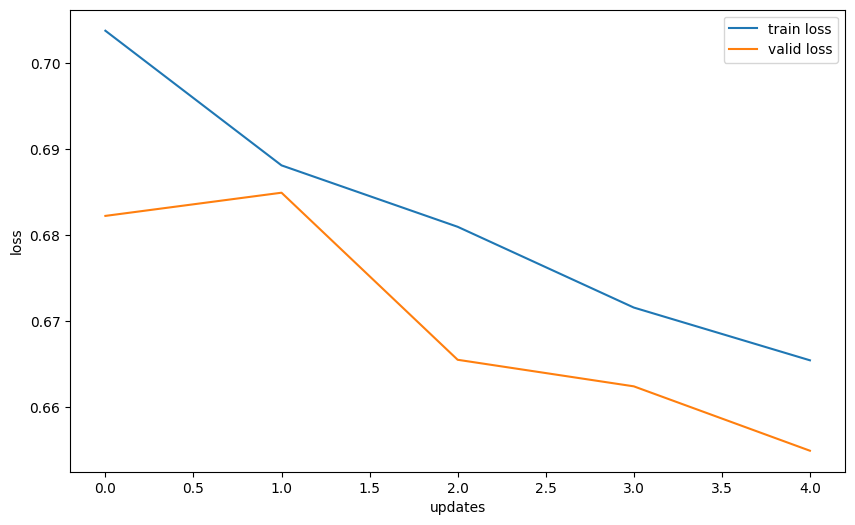

In [67]:
##Plot the training loss and the accuracy
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

# Lets Try the LSTM model

In [80]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #mkaing each batch batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [],[],[]
    for (_text,_label,) in batch:
        label_list.append(label_pipeline(_label)) # (3, 1, 0, 2, 1)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #(0, 44, 25, 1)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
    return torch.tensor(label_list,dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix,batch_first=True), \
        torch.tensor(length_list,dtype=torch.int64)

In [81]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)

In [82]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

In [83]:
import torch.nn as nn

class LSTM(nn.Module):
    # pass #replace this line with the real code
    def __init__(self,input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup to ignore and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, 
                            hid_dim, 
                            num_layers = num_layers, 
                            bidirectional = bidirectional, 
                            dropout = dropout, #dropout is applied between layers
                            batch_first = True) 
        self.fc = nn.Linear(hid_dim*2, output_dim)
    def forward(self, x, lengths):

        #x : [batch size, seq len]
        embedded_x = self.embedding(x)
        #x : [batch size, seq len, emb dim]

        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch first = True; thing will become [seq len, batch size, emb size]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, 
                                                            lengths.to('cpu'),
                                                            enforce_sorted=False,
                                                            batch_first=True)
        #packed_output is basically all hidden states ==> POS tagging, NER

        #h is the last hidden state => sentiment analysis
        #c is the last cell state
        packed_output, (h,c) = self.lstm(pack_embedded)

        #h : [num_layers * num_directions, batch_size, hidden dim] 

        #it happen that because packed_ouputs is all hidden states... some hidden state near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pack_padded_sequence, them all the hiddden states will only be not padding
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output,batch_first=True)

        #last hidden state - concat forward and backward states
        last_hidden_state = torch.cat((h[-1,:,:], h[-2,:,:]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]

        #for sentiment analysis... what whould i sent to my linear layer.....
        return self.fc(last_hidden_state) #[batch_size, output_dim] ==> [batch_size,4]

In [84]:
input_dim  = len(vocab)
emb_dim    = 300 #same as above
hidden_dim = 256 #how many hidden dims do you want?
output_dim = 2#same as above
dropout    = 0.5
num_layers = 2
bidirectional = True 

lstm_model = LSTM(input_dim, emb_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout).to(device)
lstm_model.apply(initialize_weights)
lstm_model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [85]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #

In [86]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model 
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [87]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate the model
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [88]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))

In [89]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [90]:
best_valid_loss = float('inf')
num_epochs   = 5



train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    #write the code that starts the training, store the training and valid losses and accuracy
    #also print the time it took to train the model
    start_time = time.time()

    train_loss, train_acc = train(lstm_model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(lstm_model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
      
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 1m 47s
	Train Loss: 0.511 | Train Acc: 75.70%
	 Val. Loss: 0.426 |  Val. Acc: 87.85%
Epoch: 02 | Time: 2m 17s
	Train Loss: 0.291 | Train Acc: 88.25%
	 Val. Loss: 0.291 |  Val. Acc: 86.98%
Epoch: 03 | Time: 2m 16s
	Train Loss: 0.116 | Train Acc: 95.44%
	 Val. Loss: 0.495 |  Val. Acc: 80.38%
Epoch: 04 | Time: 2m 11s
	Train Loss: 0.043 | Train Acc: 98.49%
	 Val. Loss: 0.323 |  Val. Acc: 87.33%
Epoch: 05 | Time: 2m 9s
	Train Loss: 0.030 | Train Acc: 99.12%
	 Val. Loss: 0.543 |  Val. Acc: 80.21%


Text(0, 0.5, 'loss')

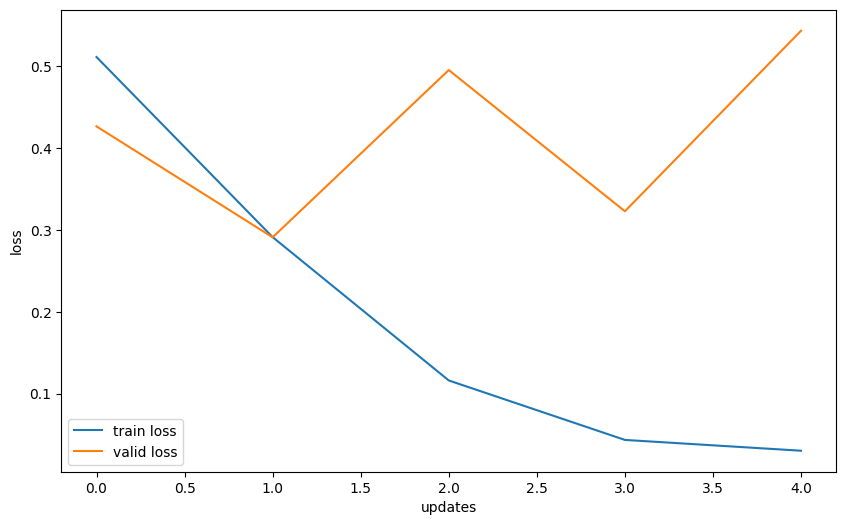

In [91]:
##Plot the losses and accuracy over all epochs
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## Conclusion

1. Compare the two models on their time and accuracy. Which one do you think did well for the disaster classification task.
- LSTM can perform a higher accuracy than CNN.
2. How do you think we get better results in this dataset for classification.
- It getting better since this dataset we have clean and working on the value data.